  0%|          | 0/30 [00:00<?, ?it/s]

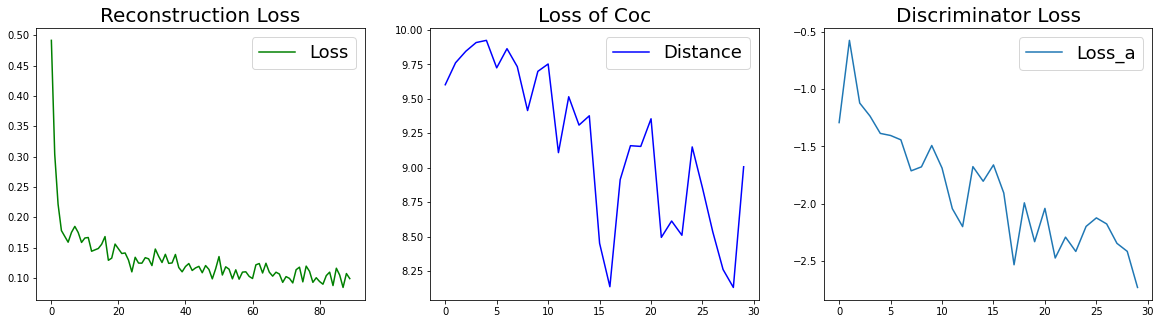

In [32]:
'''
This notebook is the demostration of our paper 'Coc & Drop-Loss: Rectify the Unexpected Fitting Issues in KPIs
Anomaly Detection'.
Here, we take the univariate time series anomaly detection on the UCR dataset as an example.
'''

from model import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
from spot import SPOT
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.manifold import TSNE
from tadpak import pak
import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# the sliding function
def sliding_window(x, window_length=25, stride=25):
    length = x.shape[0]
    num = int(np.floor((length - window_length) / stride) + 1)
    x_out = []
    for i in range(num):
        x_out.append(x[i * stride:i * stride + window_length])
    x_out = np.array(x_out, dtype=np.float32).reshape(num, window_length, -1)
    return x_out

train_data = pd.read_csv('data/train.csv', index_col=0)
test_data = pd.read_csv('data/test.csv', index_col=0)

# construct trainig set and test set
length = 200 
scaler = StandardScaler()
train = tf.clip_by_value(scaler.fit_transform(train_data), -3, 10)
test = tf.clip_by_value(scaler.transform(test_data), -3, 10)
train = sliding_window(train, window_length=length, stride=10)
test = sliding_window(test, window_length=length, stride=length)
train_db = tf.data.Dataset.from_tensor_slices(train).batch(128).prefetch(tf.data.AUTOTUNE)

# paramaters of AE-GAN
en_param = [[3, 2, 50]] # encoder
de_param = [[length]]   # decoder
dis_param = [[3, 1, 60],# discriminator
             [3, 2, 8]]
DIS_EPOCHES = [1]*30    # training epochs of discriminator
GEN_EPOCHES = [3]*30    # training epochs of generator

# build the model
model = Tan([en_param, de_param], dis_param,                                   # k, r_lr, and std are the key paramaters of
            [DIS_EPOCHES, GEN_EPOCHES], k=10, r_lr=0.001, std=3, factor=0.01)  # the proposed methods
model.train(train_db)
loss, dist, d_loss = model.get_loss()

# training curves
plt.figure(figsize=[20,5])

plt.subplot(131)
plt.plot(loss, 'g', label='Loss')
plt.title('Reconstruction Loss', fontdict={'size':20})
plt.legend(fontsize=18)

plt.subplot(132)
plt.plot(dist, 'b', label='Distance')
plt.title('Loss of Coc', fontdict={'size':20})
plt.legend(fontsize=18)

plt.subplot(133)
plt.plot(d_loss, label='Loss_a')
plt.title('Discriminator Loss', fontdict={'size':20})
plt.legend(fontsize=18)

# visualize the reconstruction on test set

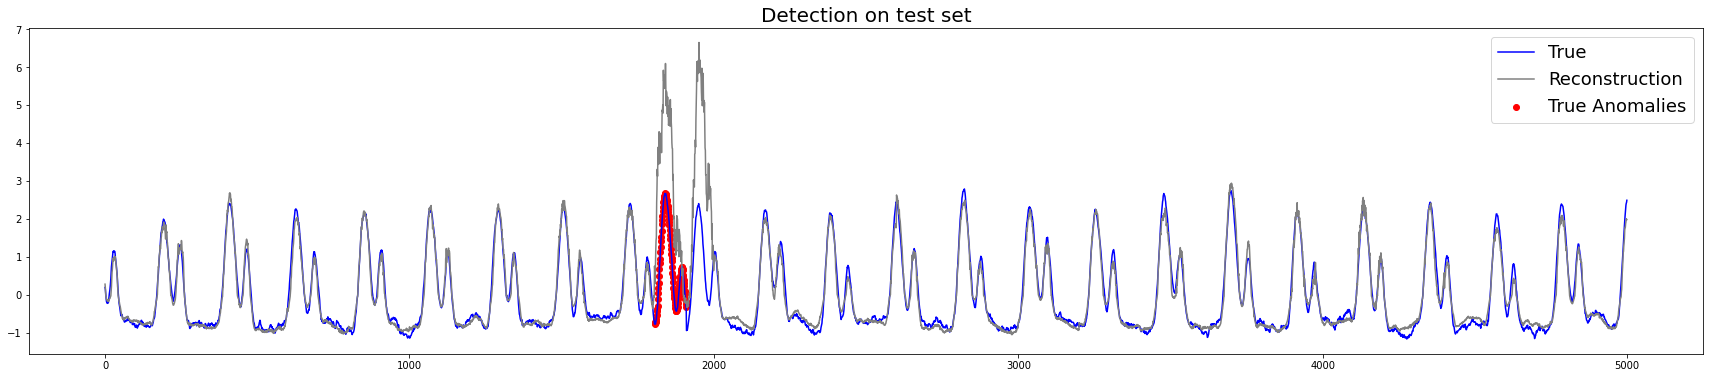

In [33]:
test_label = pd.read_csv('data/test_label.csv', index_col=0, header=0).reset_index(drop=True)
test_pred = tf.reshape(model.gen(test, trainable=False), [-1, 1])
test_true = test.reshape(-1, 1)

plt.figure(figsize=[30, 6])
plt.plot(test_true[:, 0], 'b', label='True')
plt.plot(test_pred[:, 0], 'grey', label='Reconstruction')
plt.title('Detection on test set', fontdict={'size':20})
index = test_label[test_label.iloc[:, 0] == 1].index
plt.scatter(index, test_true[index, 0], c='r', label='True Anomalies')
plt.legend(fontsize=18)

# Detect and evaluate the results

In [34]:
def thresh(init_data, data, q=1e-4):
    s = SPOT(q)
    s.fit(init_data, data)
    s.initialize(verbose=False)
    results = s.run()
    return s, results

def detect(train_res, true, pred, label, k=0):
    res = np.abs(true-pred)
    score = [0,0,0,0]
    for q in [1e-2, 5e-3,1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]: # grid search the best q
        s, results = thresh(train_res[-1000:,0], res, q=q)
        adjust_predict = pak.pak(res.reshape(-1), label.reshape(-1), results['thresholds'], k=k)
        f1, recall, precision = f1_score(label, adjust_predict), \
                                recall_score(label, adjust_predict), \
                                precision_score(label, adjust_predict)
        if score[0] < f1:
            score = [round(f1,4), round(recall, 4), round(precision,4), q]
    return score

n = len(test_true)
train_pred = tf.reshape(model.gen(train, trainable=False), [-1, 1])
train_true = train.reshape(-1, 1)
train_res = np.abs(train_pred-train_true)
result_0 = detect(train_res, test_true, test_pred.numpy(), test_label.to_numpy()[:n], k=0)
result_5 = detect(train_res, test_true, test_pred.numpy(), test_label.to_numpy()[:n], k=5)
result_20 = detect(train_res, test_true, test_pred.numpy(), test_label.to_numpy()[:n], k=20)
result_100 = detect(train_res, test_true, test_pred.numpy(), test_label.to_numpy()[:n], k=100)

print('     ', 'F1-score', 'Recall', 'Precision', 'q')
print('PA%0:', result_0)
print('PA%5:',result_5)
print('PA%20:',result_20)
print('PA%100:',result_100)

      F1-score Recall Precision q
PA%0: [0.7482, 1.0, 0.5977, 1e-06]
PA%5: [0.7482, 1.0, 0.5977, 1e-06]
PA%20: [0.7482, 1.0, 0.5977, 1e-06]
PA%100: [0.6512, 0.8077, 0.5455, 5e-05]


# Visualization of the detection results

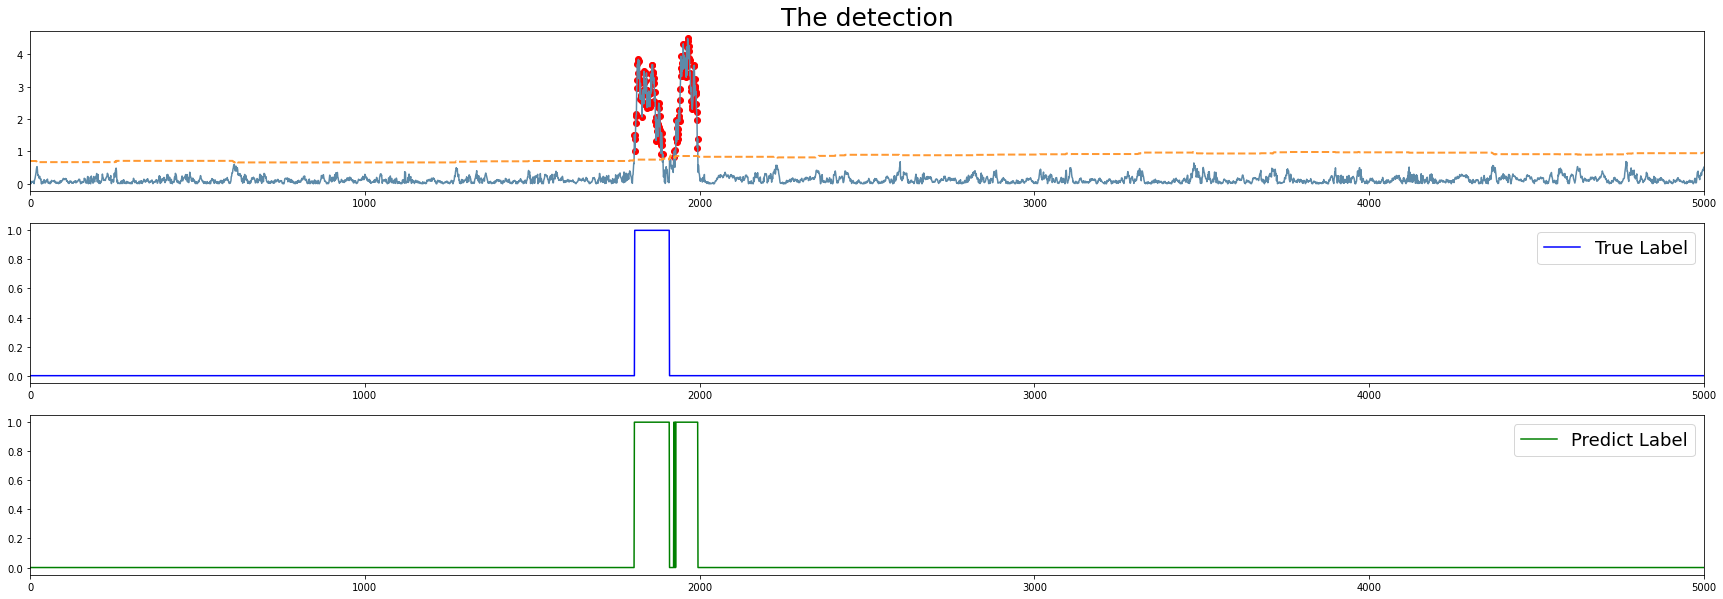

In [35]:
test_res = np.abs(test_true-test_pred)
s, results = thresh(train_res[-1000:,0], test_res, q=1e-6)
adjust_predict = pak.pak(test_res.reshape(-1), test_label.to_numpy()[:n].reshape(-1), results['thresholds'], k=10)

plt.figure(figsize=[30,10])
plt.subplot(3,1,1)
s.plot(results)
plt.title('The detection', fontdict={'size':25})
# The blue line is the prediction residual, 
# the orange dashed line is the threshold, 
# and the red dot is the predicted anomalies.

plt.subplot(3,1,2)
plt.plot(test_label.iloc[:,0], 'b', label='True Label')
plt.xlim(0,5000)
plt.legend(fontsize=18)

plt.subplot(3,1,3)
plt.plot(adjust_predict, 'green', label='Predict Label')
plt.xlim(0,5000)
plt.legend(fontsize=18)

# Visualize the latent space

Text(0.5, 1.0, 'Visualization of the latent space')

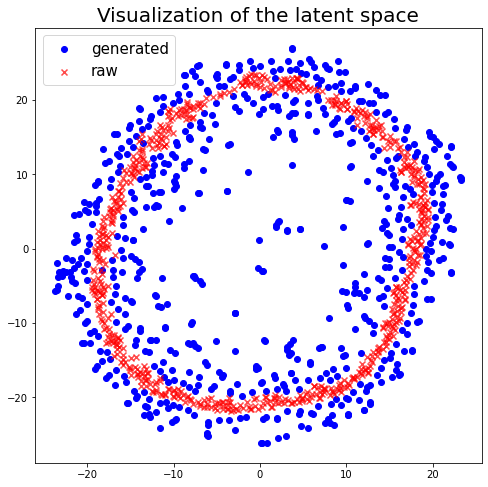

In [36]:
latent = model.gen.en_call(train, trainable=False)
latent_ = model.latent_generator(latent)
reducer = TSNE(n_components=2, perplexity=50, n_jobs=-1)
p = latent.shape[0]
data_ = tf.concat([tf.reshape(latent[...,0], [-1,50]), tf.reshape(latent_[...,0], [-1,50])], axis=0)
data = reducer.fit_transform(data_)

# visualize the annular manifold of time series
plt.figure(figsize=(8,8))
plt.scatter(data[p:,0], data[p:,1], c='b', label='generated')
plt.scatter(data[:p,0], data[:p,1], c='r', label='raw',alpha=0.7, marker='x')
plt.legend(fontsize=15)
plt.title('Visualization of the latent space', fontdict={'size':20})